In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"  # In case MKL is used instead of OpenBLAS
import sys
from pathlib import Path
import torch
import numpy as np
import pandas as pd

# 1.1 Import Metrics

In [2]:
sys.path.append("../")
# Import the metrics function
from metric.evaluator import train_evaluator
from metric.pca import *
from metric.fst import *
from metric.umap import *
from metric.precision_recall import *
from metric.correlation_score import *
from metric.aats import *
from metric.basic_sanity_check import *
from metric.allele_freq import *
from metric.geno_freq import *
from metric.LD import *
from metric.GWAS import *

2025-07-30 13:03:58.729156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-30 13:03:58.729250: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-30 13:03:58.729329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 13:03:58.744787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-30 13:04:00.301649: W tensorflow/compiler/

# 1.2 Import Trained Models

## Import and Load trained VAE

In [3]:
# Import Trained Models
sys.path.append("../models/VAE/cows/CH14")
## VAE for Cow CH14
from vae_model import VAE
# Load Configuration
from vae_cow_ch14_configs import (
    sequence_length,
    batch_size,
    learning_rate,
    num_epochs,
    encoder_dims,
    decoder_dims,
    latent_dim,
    step,
    device
) # You may need to adjust the device configuration based on your available CPU or GPU

In [4]:
vae = VAE(sequence_length, latent_dim, encoder_dims, decoder_dims).to(device)

In [5]:
vae.decoder.load_state_dict(torch.load("../models/VAE/cows/CH14/vae_cow_ch14.pth"))

<All keys matched successfully>

## Import and Load trained GAN+GS

In [6]:
# Import Trained Models
sys.path.append("../models/GAN_GS/cows/CH14")
## VAE for Cow CH14
from gan_model import GAN
# Load Configuration
from gan_cow_ch14_configs import (CONFIG_GAN_COW_CH14,device) # You may need to adjust the device configuration based on your available CPU or GPU

In [7]:
gan = GAN(CONFIG_GAN_COW_CH14, device)

In [8]:
gan.G.load_state_dict(torch.load("../models/GAN_GS/cows/CH14/gan_cow_ch14.pth"))

<All keys matched successfully>

# 2 Generate Synthetic Data

## Using VAE to generate synthetic data

In [9]:
vae.eval()
VAE_AGs = []
for i in range(5):
    AG = vae.generate(10000)
    VAE_AGs.append(pd.DataFrame(AG,dtype=float))

## Using GAN+GS to generate synthetic data

In [10]:
GAN_AGs = []
for i in range(5):
    AG = gan.generate_fake(10000, temperature=CONFIG_GAN_COW_CH14['final_temp'])
    GAN_AGs.append(pd.DataFrame(AG,dtype=float))

# 3 Compute the evaluation metrics

## PCA and UMAP

Cumulative variance explained by the first 32 PCs: 0.5740 (57.40%)


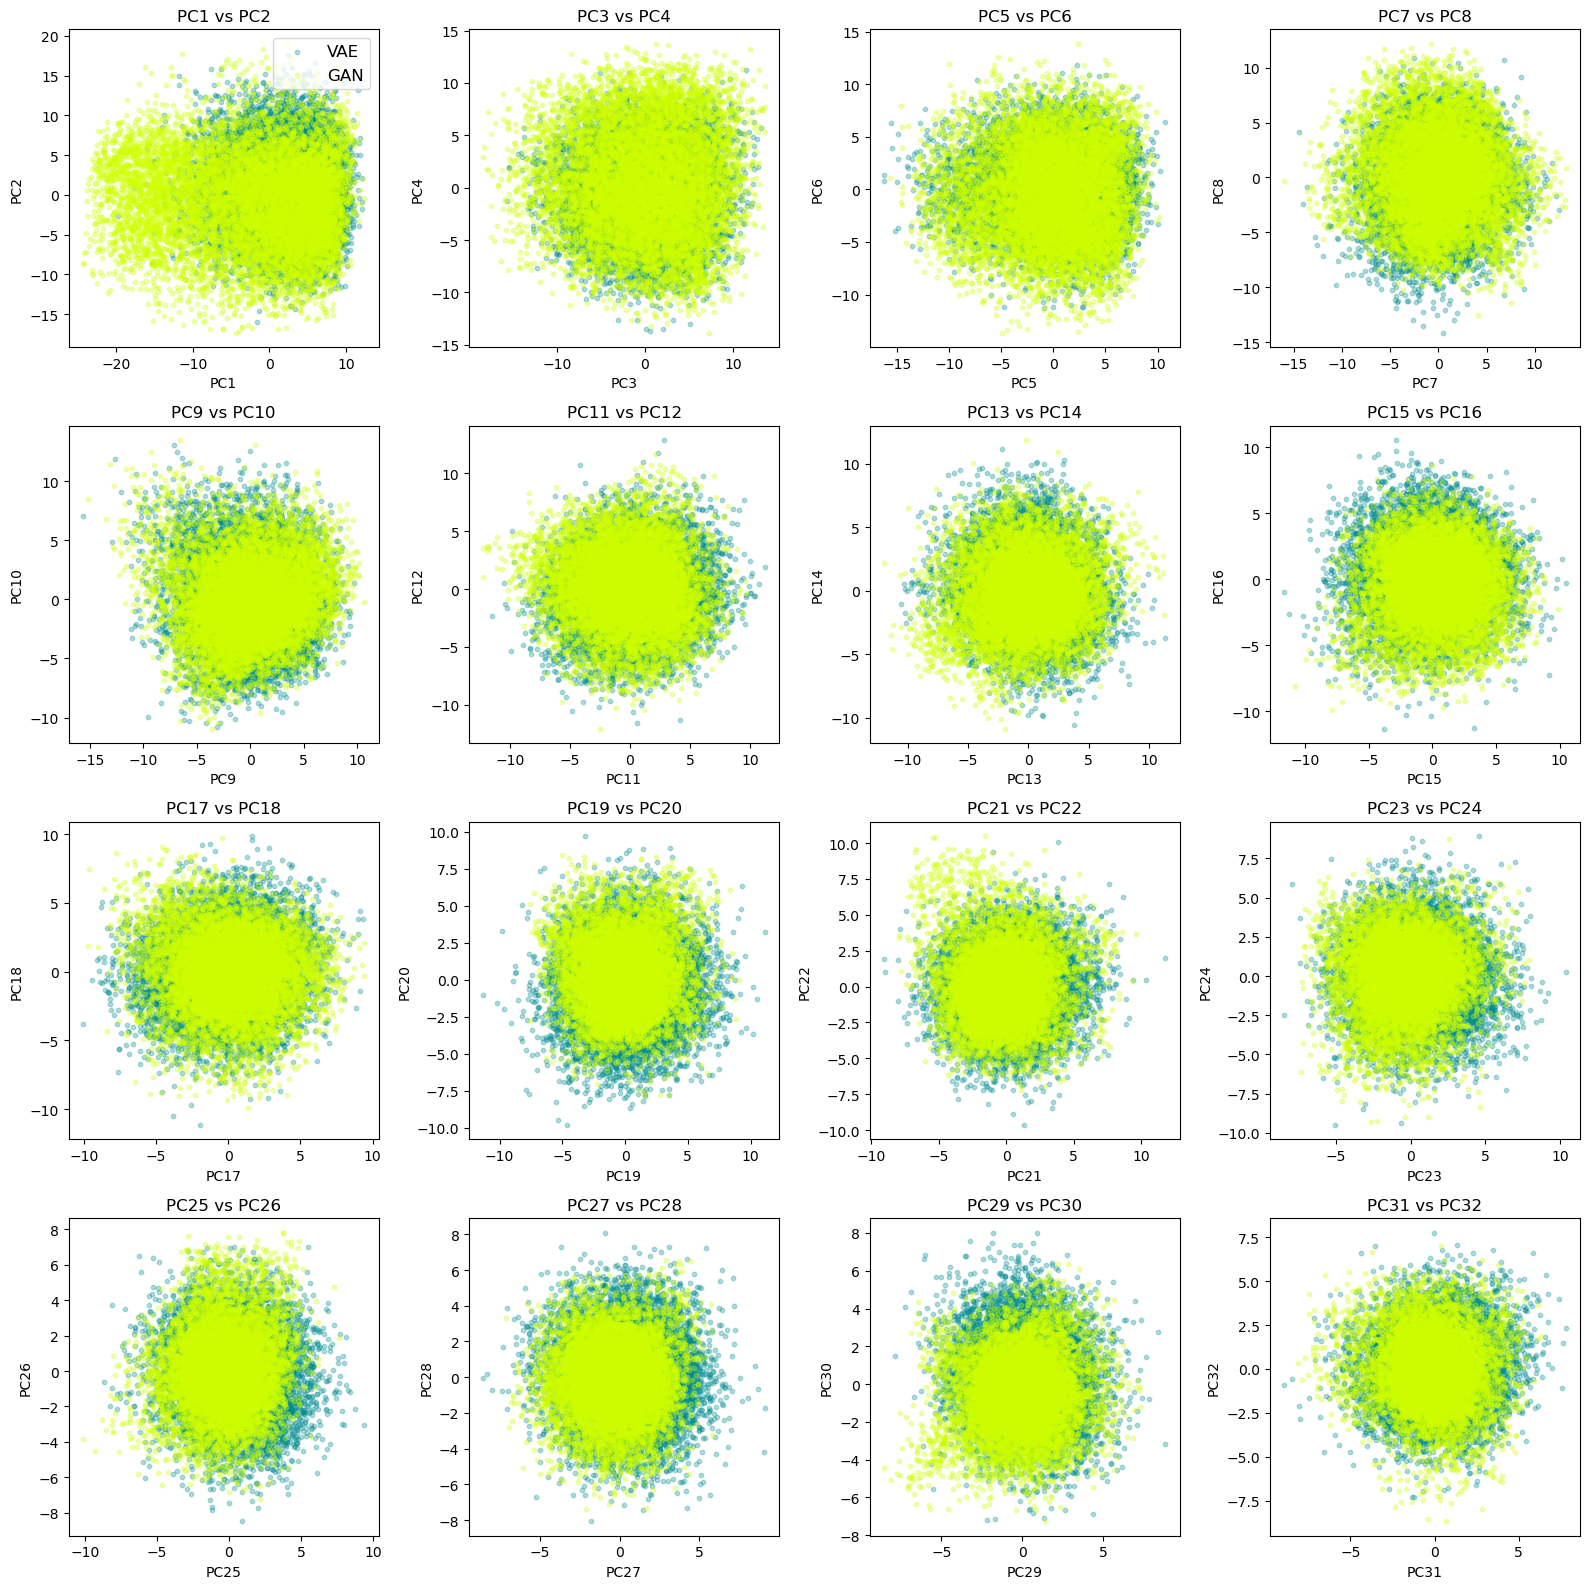

In [11]:
geno_PCA_32PC(VAE_AGs[0],GAN_AGs[0],'VAE','GAN',"PCA_32PC")

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


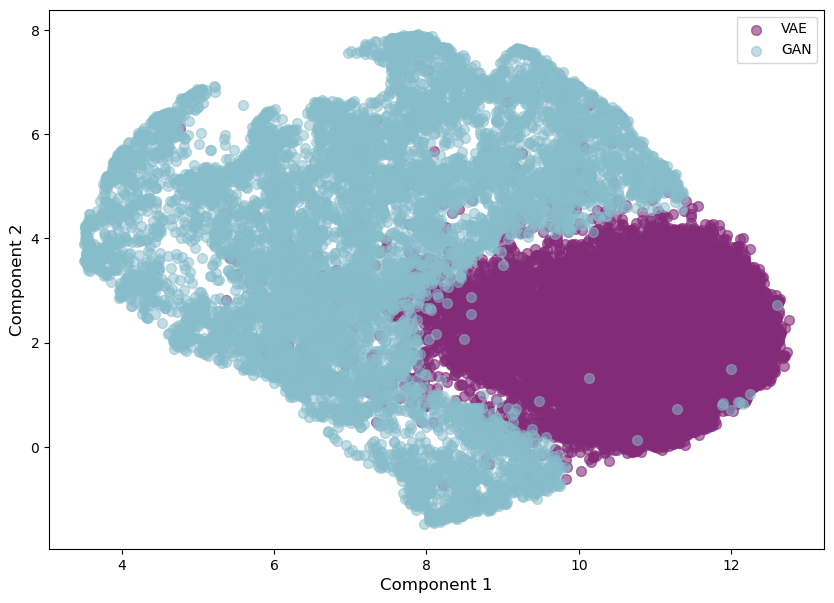

In [12]:
geno_UMAP(VAE_AGs[0],GAN_AGs[0],'VAE','GAN',"UMAP")

## Fixation Index

In [13]:
result_fst = []
for i in range(len(VAE_AGs)):
    result_fst.append(aggregated_fst(VAE_AGs[i], GAN_AGs[i]))
average_metric = np.mean(result_fst)
precision = np.std(result_fst, ddof=1)  # ddof=1 for sample standard deviation
print("{:.6f} ± {:.6f}".format(average_metric, precision))

0.006948 ± 0.000070


## Precision and Recall

In [14]:
precisions,recalls, f1s = [],[],[]
for i in range(len(VAE_AGs)):
    precision, recall = get_precision_recall(torch.tensor(VAE_AGs[i].to_numpy()).to(dtype=torch.float32), torch.tensor(GAN_AGs[i].to_numpy()).to(dtype=torch.float32), ks=[60], distance = "euclidean")
    f1_score = 2 * (precision * recall) / (precision + recall)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1_score)

Evaluated k-NN precision and recall in: 8.94693s
Evaluated k-NN precision and recall in: 8.91078s
Evaluated k-NN precision and recall in: 9.07078s
Evaluated k-NN precision and recall in: 9.07657s
Evaluated k-NN precision and recall in: 9.4931s


In [15]:
# Precisions
average_metric = np.mean(precisions)
precision = np.std(precisions, ddof=1)
print("{:.6f} ± {:.6f}".format(average_metric, precision))

0.902660 ± 0.001494


In [16]:
# Recalls
average_metric = np.mean(recalls)
precision = np.std(recalls, ddof=1) 
print("{:.6f} ± {:.6f}".format(average_metric, precision))

0.588240 ± 0.011105


In [17]:
# F1
average_metric = np.mean(f1s)
precision = np.std(f1s, ddof=1)
print("{:.6f} ± {:.6f}".format(average_metric, precision))

0.712245 ± 0.008104


## Allele and Genotype Frequency

/home/jovyan/workspace/github_repo/DevDiscreteGenoGen/DiscreteGenoGen/demo/../metric/allele_freq.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'r--', color="#FF6F43", label='y = x (Ideal Match)')


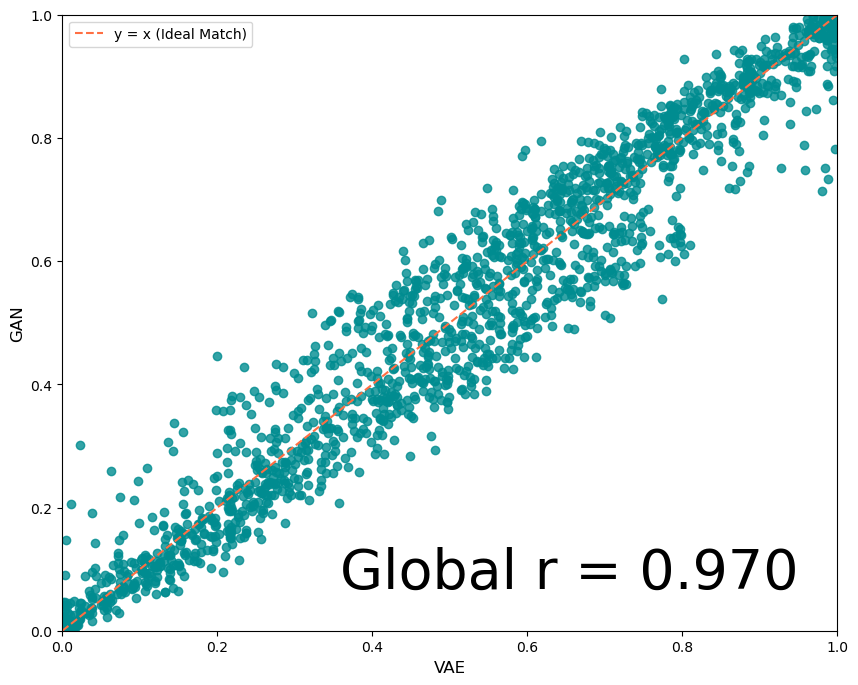

In [18]:
plot_allele_freq(VAE_AGs[0],GAN_AGs[0],'VAE','GAN',"allele_freq")

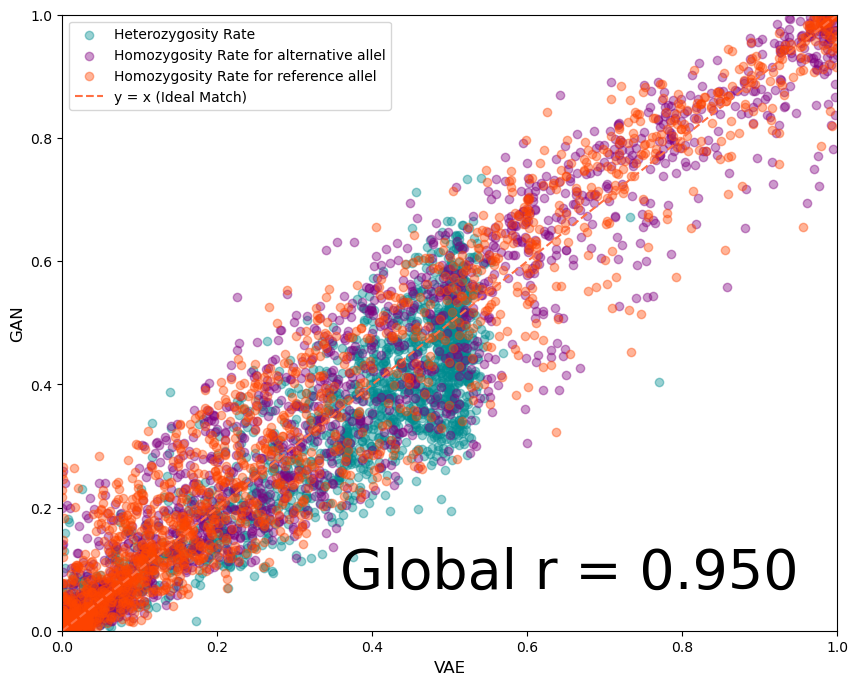

In [19]:
plot_geno_freq(VAE_AGs[0],GAN_AGs[0],'VAE','GAN',"geno_freq")

## Adversarial Accuracy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


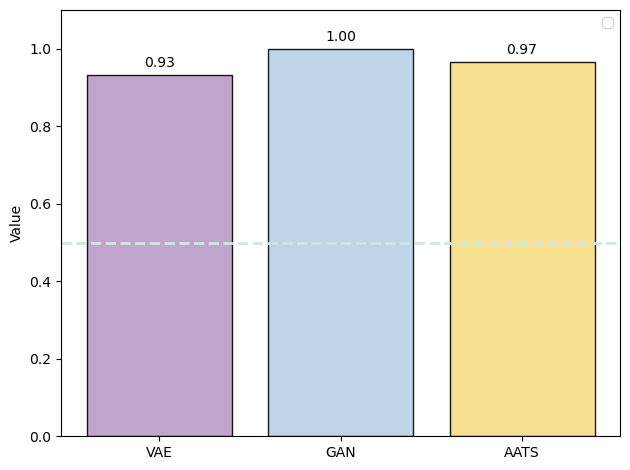

In [20]:
plot_aats(AATS(VAE_AGs[0],GAN_AGs[0], metric="euclidean"),'VAE','GAN',"AA")

## Correlation Score

In [21]:
result_corr = []
for i in range(len(VAE_AGs)):
    result_corr.append(corr_score(VAE_AGs[0],GAN_AGs[0]))
average_metric = np.mean(result_corr)
precision = np.std(result_corr, ddof=1)
print("{:.6f} ± {:.6f}".format(average_metric, precision))

0.710511 ± 0.000000


## LD and LD Decay

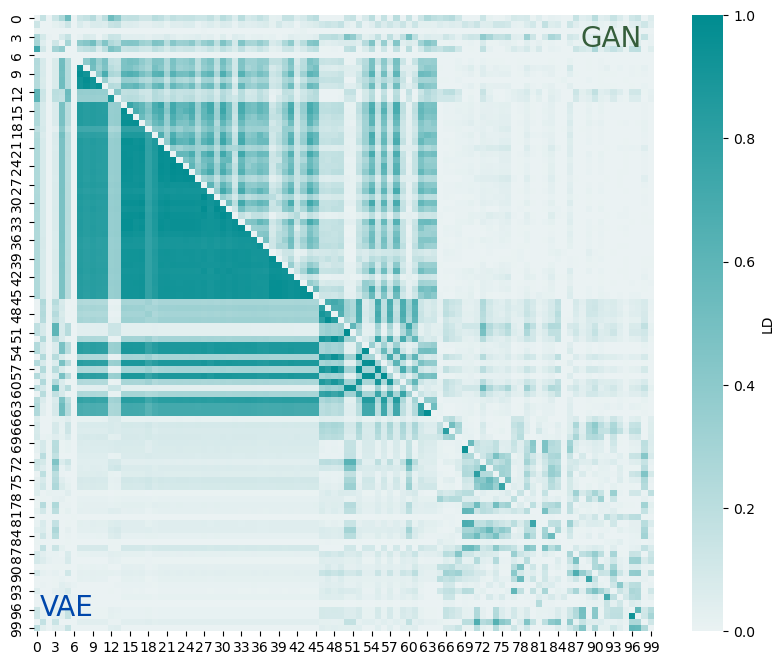

In [22]:
plot_LD(VAE_AGs[0].iloc[:, :100],GAN_AGs[0].iloc[:, :100],"VAE","GAN","LD_100snps")

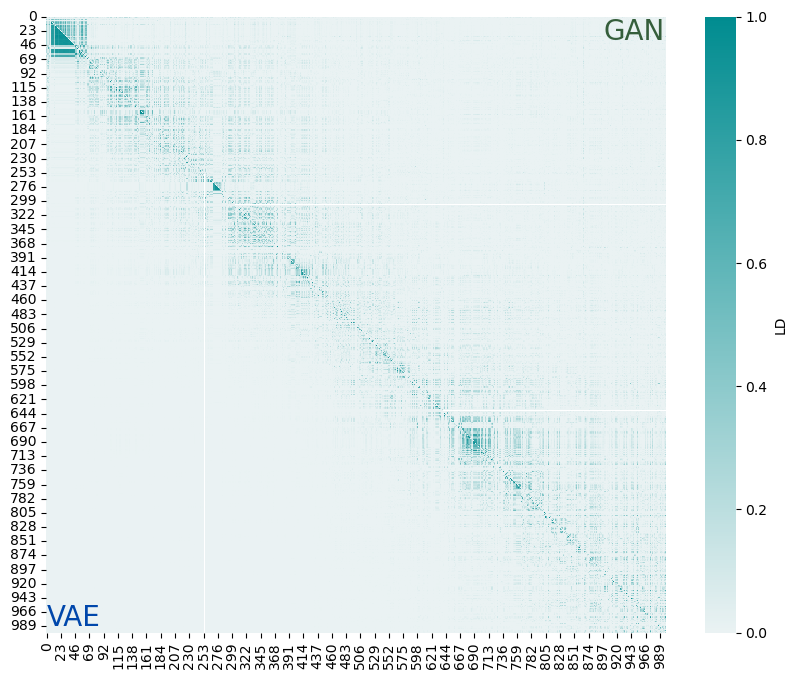

In [23]:
plot_LD(VAE_AGs[0].iloc[:, :1000],GAN_AGs[0].iloc[:, :1000],"VAE","GAN","LD_1000snps")

In [24]:
cow_ch14 = pd.read_csv("../metadata/cow_snp_position_by_chr.csv")
cow_ch14_positions = cow_ch14[cow_ch14["Chromosome"] == 14]["Position_BP"].to_numpy()

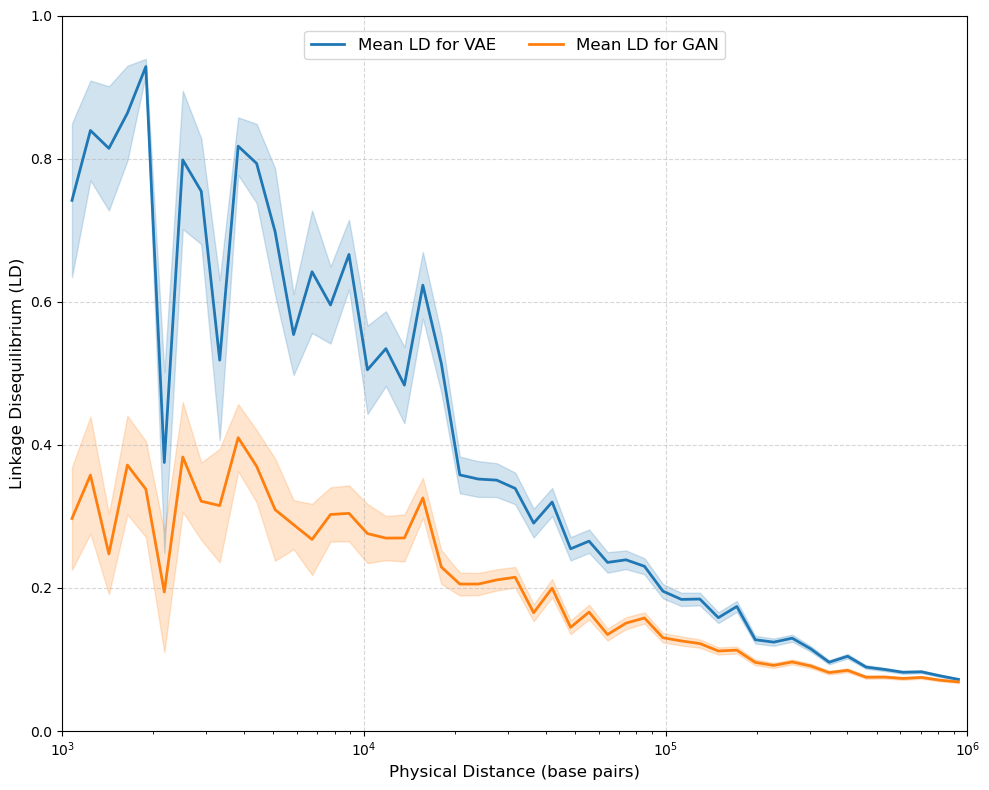

In [25]:
plot_LD_decay(VAE_AGs[0], GAN_AGs[0], cow_ch14_positions, 10**6, 10**3, 10**6, 'VAE', 'GAN', "LD_DECAY")